<a href="https://colab.research.google.com/github/carlosaragao/U-NET-ORIGA-FINAL/blob/main/Unet_Origa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Conectar com drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [ ]:
from scipy.io import loadmat
from PIL import Image

import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

## Pré-processamento das máscaras


In [ ]:
# Identifica chaves no arquivo .mat
def inspect_mat_files(mat_folder):
    mat_files = [f for f in os.listdir(mat_folder) if f.endswith('.mat')]

    for mat_file in mat_files:
        mat_path = os.path.join(mat_folder, mat_file)
        mat_data = loadmat(mat_path)

        print(f"Arquivo: {mat_file}")
        for key in mat_data.keys():
            if not key.startswith('__'):
                print(f"  Chave: {key}, Formato: {mat_data[key].shape}")

In [ ]:
# mat_folder = '/content/drive/MyDrive/ORIGA/Semi-automatic-annotations'
# inspect_mat_files(mat_folder)

In [ ]:
def convert_mat_to_tif(mat_folder, output_folder):
    mat_files = [f for f in os.listdir(mat_folder) if f.endswith('.mat')]

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for mat_file in mat_files:
        mat_path = os.path.join(mat_folder, mat_file)
        mat_data = loadmat(mat_path)

        # Substitua 'key' pelo nome da chave correspondente à máscara no arquivo .mat
        mask = mat_data['mask']

        # Converter a máscara para uma matriz binária (valores 0 e 1)
        mask = (mask > 0).astype(np.uint8)

        # Criar e salvar a imagem .tif
        tif_filename = os.path.splitext(mat_file)[0] + '.tif'
        tif_path = os.path.join(output_folder, tif_filename)
        im = Image.fromarray(mask * 255)
        im.save(tif_path)

In [ ]:
# mat_folder = '/content/drive/MyDrive/ORIGA/Semi-automatic-annotations'
# output_folder = '/content/drive/MyDrive/ORIGA/Masks_tif'
# convert_mat_to_tif(mat_folder, output_folder)

## Carregamento das imagens

In [ ]:
# Carregar o arquivo CSV
origa_list = pd.read_csv('/content/drive/MyDrive/ORIGA/OrigaList.csv')

In [ ]:
origa_list.head()

,Eye,Filename,ExpCDR,Set,Glaucoma
0,OD,001.jpg,0.7097,A,0
1,OS,002.jpg,0.6953,A,0
2,OS,003.jpg,0.9629,A,0
3,OD,004.jpg,0.7246,A,0
4,OS,005.jpg,0.6138,A,0


In [ ]:
# Dividir o conjunto de dados em treinamento e validação (70% treinamento, 30% validação)
train_df, val_df = train_test_split(origa_list, test_size=0.3, random_state=42, stratify=origa_list['Glaucoma'])

In [ ]:
# Função para carregar e pré-processar as imagens e máscaras
def load_and_preprocess_images(df, img_path, mask_path):
    img_list = []
    mask_list = []

    for _, row in df.iterrows():
        # Carregar a imagem e a máscara
        img = Image.open(os.path.join(img_path, row["Filename"]))
        mask_filename = os.path.splitext(row["Filename"])[0] + ".tif"  # Converter a extensão do arquivo para .tif
        mask = Image.open(os.path.join(mask_path, mask_filename))

        # Converter a imagem para escala de cinza
        img = img.convert("L")

        # Redimensionar as imagens e máscaras para as dimensões desejadas (256x256, por exemplo)
        img = img.resize((256, 256))
        mask = mask.resize((256, 256))

        # Converter as imagens e máscaras para arrays numpy e normalizar os valores
        img_array = np.array(img) / 255.0
        mask_array = np.array(mask) / 255.0

        img_list.append(img_array)
        mask_list.append(mask_array)

    # Adiciona uma dimensão extra nas imagens para indicar que elas estão em escala de cinza (1 canal)
    return np.array(img_list)[..., np.newaxis], np.array(mask_list)[..., np.newaxis]

In [ ]:
# Caminho dos arquivos
path_images = '/content/drive/MyDrive/ORIGA/Images'
path_masks = '/content/drive/MyDrive/ORIGA/Masks_tif'

In [ ]:
# Carregar e pré-processar as imagens e máscaras de treinamento e validação
train_imgs, train_masks = load_and_preprocess_images(train_df, path_images, path_masks)
val_imgs, val_masks = load_and_preprocess_images(val_df, path_images, path_masks)

In [ ]:
print("Formato das imagens de treinamento:", train_imgs.shape)
print("Formato das máscaras de treinamento:", train_masks.shape)
print("Formato das imagens de validação:", val_imgs.shape)
print("Formato das máscaras de validação:", val_masks.shape)

Formato das imagens de treinamento: (455, 256, 256, 1)
Formato das máscaras de treinamento: (455, 256, 256, 1)
Formato das imagens de validação: (195, 256, 256, 1)
Formato das máscaras de validação: (195, 256, 256, 1)


## Definindo arquitetura U-NET

In [ ]:
from tensorflow.keras import layers

def conv_block(input_tensor, num_filters):
    x = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = layers.concatenate([x, concat_tensor])

    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x1, p1 = encoder_block(inputs, 64)
    x2, p2 = encoder_block(p1, 128)
    x3, p3 = encoder_block(p2, 256)
    x4, p4 = encoder_block(p3, 512)

    # Bridge
    bridge = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(bridge, x4, 512)
    d2 = decoder_block(d1, x3, 256)
    d3 = decoder_block(d2, x2, 128)
    d4 = decoder_block(d3, x1, 64)

    # Output
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(d4)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Função de perda Dice
def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [ ]:
# Parâmetros do modelo
input_shape = (256, 256, 1)

# Construir e compilar o modelo U-Net
unet = build_unet(input_shape)
unet.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=["accuracy"])

In [ ]:
# Treinar o modelo U-Net
history = unet.fit(train_imgs, train_masks, validation_data=(val_imgs, val_masks), epochs=50, batch_size=16, shuffle=True)

Epoch 1/50
29/29 [==============================] - 29s 1s/step - loss: 0.5593 - accuracy: 0.9935 - val_loss: 0.7715 - val_accuracy: 0.9884
Epoch 2/50
29/29 [==============================] - 28s 956ms/step - loss: 0.5369 - accuracy: 0.9939 - val_loss: 0.8410 - val_accuracy: 0.9846
Epoch 3/50
29/29 [==============================] - 29s 1s/step - loss: 0.5206 - accuracy: 0.9936 - val_loss: 0.7801 - val_accuracy: 0.9855
Epoch 4/50
29/29 [==============================] - 28s 962ms/step - loss: 0.4961 - accuracy: 0.9943 - val_loss: 0.6912 - val_accuracy: 0.9870
Epoch 5/50
29/29 [==============================] - 28s 960ms/step - loss: 0.4782 - accuracy: 0.9941 - val_loss: 0.6157 - val_accuracy: 0.9878
Epoch 6/50
29/29 [==============================] - 29s 1s/step - loss: 0.4584 - accuracy: 0.9943 - val_loss: 0.6254 - val_accuracy: 0.9748
Epoch 7/50
29/29 [==============================] - 29s 1s/step - loss: 0.4422 - accuracy: 0.9943 - val_loss: 0.5421 - val_accuracy: 0.9883
Epoch 8/50


In [ ]:
# Salvar o modelo treinado
unet.save("glaucoma_unet.h5")

## Plots


In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot da loss de treinamento e validação
    ax1.plot(history.history['loss'], label='Train')
    ax1.plot(history.history['val_loss'], label='Validation')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot da acurácia de treinamento e validação
    ax2.plot(history.history['accuracy'], label='Train')
    ax2.plot(history.history['val_accuracy'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

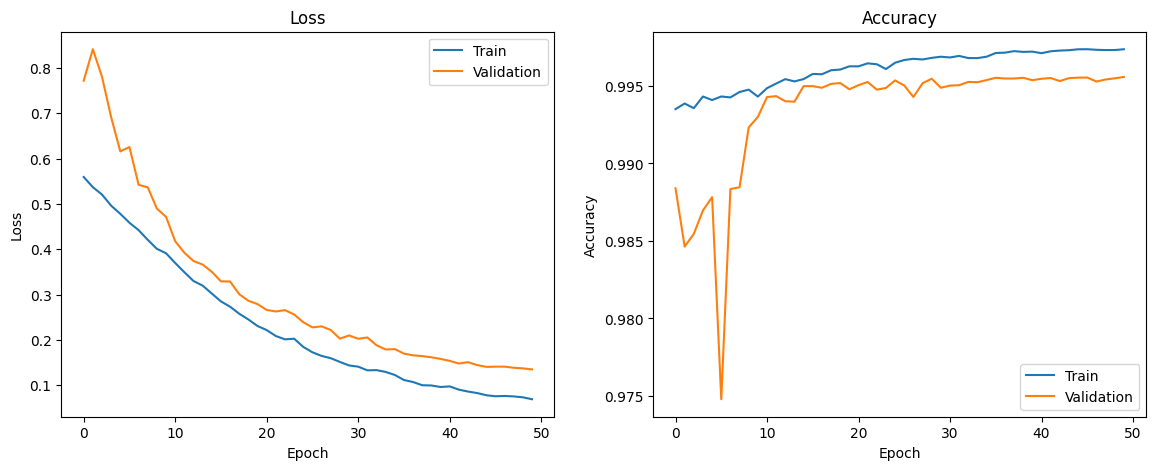

In [ ]:
plot_training_history(history)

## Predição das imagens

7/7 [==============================] - 3s 526ms/step


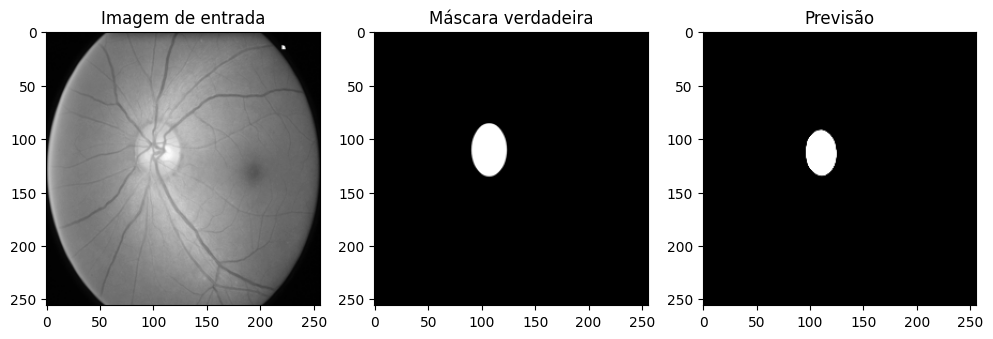

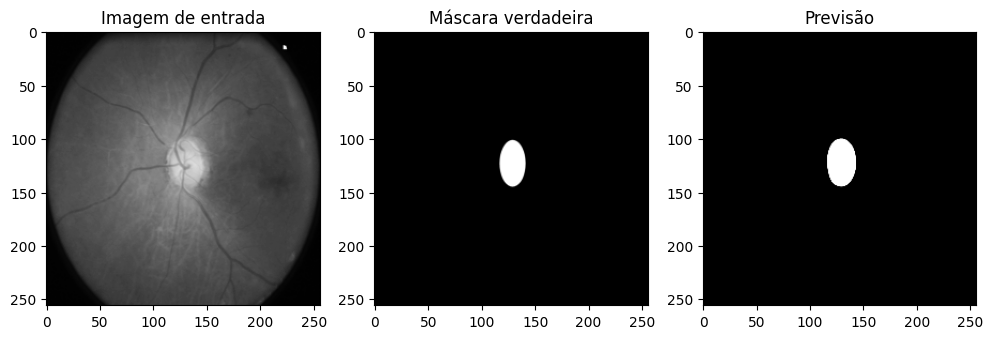

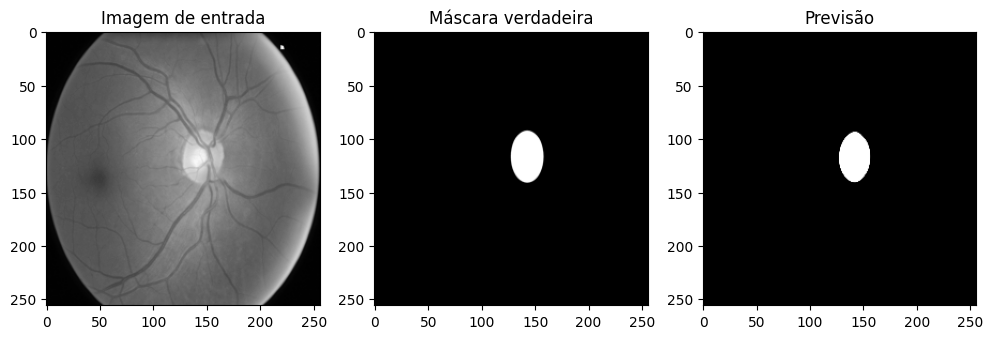

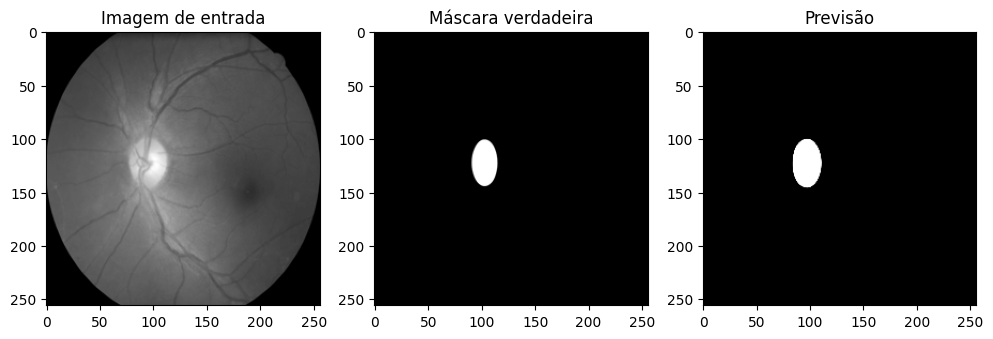

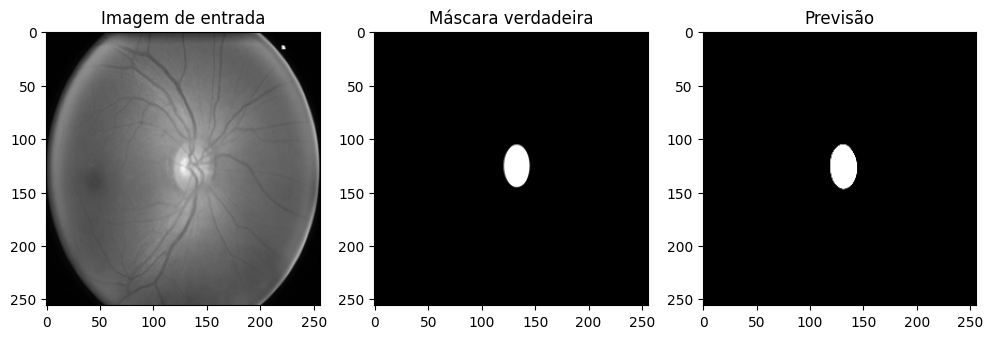

In [ ]:
val_preds = unet.predict(val_imgs)
num_samples = 5  # Número de amostras para visualizar

for i in range(num_samples):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    ax1.imshow(val_imgs[i, ..., 0], cmap='gray')
    ax1.set_title('Imagem de entrada')

    ax2.imshow(val_masks[i, ..., 0], cmap='gray')
    ax2.set_title('Máscara verdadeira')

    ax3.imshow(val_preds[i, ..., 0], cmap='gray')
    ax3.set_title('Previsão')

    plt.show()

## Medindo acurácia

### Padrão

In [ ]:
# Avaliar o modelo no conjunto de validação
loss, accuracy = unet.evaluate(val_imgs, val_masks)

print(f"Acurácia no conjunto de validação: {accuracy * 100:.2f}%")

7/7 [==============================] - 3s 438ms/step - loss: 0.1349 - accuracy: 0.9956
Acurácia no conjunto de validação: 99.56%


### IoU - Intersection over Union

In [ ]:
def calculate_iou(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    iou = intersection / union
    return iou

def evaluate_iou(model, val_imgs, val_masks):
    iou_values = []

    for img, true_mask in zip(val_imgs, val_masks):
        img = np.expand_dims(img, axis=0)
        pred_mask = model.predict(img)

        iou = calculate_iou(true_mask, pred_mask[0])
        iou_values.append(iou)

    mean_iou = np.mean(iou_values)
    return mean_iou

In [ ]:
mean_iou = evaluate_iou(unet, val_imgs, val_masks)
print(f"Média da IoU no conjunto de validação: {mean_iou:.4f}")

1/1 [==============================] - 0s 30ms/step
Média da IoU no conjunto de validação: 0.8306


### Dice

In [ ]:
def calculate_dice(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    sum_true_pred = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    epsilon = 1e-6  # Adiciona um pequeno valor para evitar divisão por zero
    dice = 2 * intersection / (sum_true_pred + epsilon)
    return dice

def evaluate_dice(model, val_imgs, val_masks):
    dice_values = []

    for img, true_mask in zip(val_imgs, val_masks):
        img = np.expand_dims(img, axis=0)
        pred_mask = model.predict(img)

        dice = calculate_dice(true_mask, pred_mask[0])
        dice_values.append(dice)

    mean_dice = np.mean(dice_values)
    return mean_dice

In [ ]:
mean_dice = evaluate_dice(unet, val_imgs, val_masks)
print(f"Média da métrica Dice no conjunto de validação: {mean_dice:.4f}")

1/1 [==============================] - 0s 21ms/step
Média da métrica Dice no conjunto de validação: 0.9028
